In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
import seaborn as sns

class CMAESAnalyzer3D:
    def __init__(self, history):
        """
        CMA-ES履歴データから3次元可視化を行うクラス

        Args:
            history: record_history()で記録された履歴データ
        """
        self.history = history
        self.generations = len(history['best_fitness'])

    def plot_fitness_convergence(self, figsize=(12, 8)):
        """フィットネス値の収束状況を可視化"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # フィットネス値の推移
        axes[0, 0].plot(self.history['best_fitness'], label='Best', color='green', linewidth=2)
        axes[0, 0].plot(self.history['mean_fitness'], label='Mean', color='blue', linewidth=2)
        axes[0, 0].plot(self.history['worst_fitness'], label='Worst', color='red', linewidth=2)
        axes[0, 0].set_xlabel('Generation')
        axes[0, 0].set_ylabel('Fitness')
        axes[0, 0].set_title('Fitness Convergence')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # 対数スケールでの表示
        axes[0, 1].semilogy(self.history['best_fitness'], label='Best', color='green', linewidth=2)
        axes[0, 1].semilogy(self.history['mean_fitness'], label='Mean', color='blue', linewidth=2)
        axes[0, 1].set_xlabel('Generation')
        axes[0, 1].set_ylabel('Fitness (log scale)')
        axes[0, 1].set_title('Fitness Convergence (Log Scale)')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # σの推移
        axes[1, 0].plot(self.history['sigma'], color='purple', linewidth=2)
        axes[1, 0].set_xlabel('Generation')
        axes[1, 0].set_ylabel('σ (Step Size)')
        axes[1, 0].set_title('Step Size Evolution')
        axes[1, 0].grid(True, alpha=0.3)

        # 固有値の推移
        eigenvals_array = np.array(self.history['eigenvalues'])
        for i in range(3):
            axes[1, 1].plot(eigenvals_array[:, i], label=f'Eigenvalue {i+1}', linewidth=2)
        axes[1, 1].set_xlabel('Generation')
        axes[1, 1].set_ylabel('Eigenvalue')
        axes[1, 1].set_title('Covariance Matrix Eigenvalues')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def plot_mean_vector_evolution(self, figsize=(15, 5)):
        """平均ベクトルの進化を可視化"""
        fig, axes = plt.subplots(1, 3, figsize=figsize)

        mean_vectors = np.array(self.history['mean_vector'])

        # 各次元の推移
        for i in range(3):
            axes[i].plot(mean_vectors[:, i], color=f'C{i}', linewidth=2)
            axes[i].set_xlabel('Generation')
            axes[i].set_ylabel(f'Mean Vector Dimension {i+1}')
            axes[i].set_title(f'Evolution of Mean Vector (Dim {i+1})')
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def plot_3d_trajectory(self, figsize=(12, 5)):
        """3次元空間での平均ベクトルの軌跡を可視化"""
        fig = plt.figure(figsize=figsize)

        # 3D軌跡
        ax1 = fig.add_subplot(121, projection='3d')
        mean_vectors = np.array(self.history['mean_vector'])

        # カラーマップで世代を表現
        colors = plt.cm.viridis(np.linspace(0, 1, len(mean_vectors)))

        # 軌跡を描画
        for i in range(len(mean_vectors)-1):
            ax1.plot([mean_vectors[i, 0], mean_vectors[i+1, 0]],
                    [mean_vectors[i, 1], mean_vectors[i+1, 1]],
                    [mean_vectors[i, 2], mean_vectors[i+1, 2]],
                    color=colors[i], linewidth=2)

        # 開始点と終了点をマーク
        ax1.scatter(*mean_vectors[0], color='red', s=100, label='Start', alpha=0.8)
        ax1.scatter(*mean_vectors[-1], color='green', s=100, label='End', alpha=0.8)

        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        ax1.set_title('3D Trajectory of Mean Vector')
        ax1.legend()

        # 2D投影（XY平面）
        ax2 = fig.add_subplot(122)
        for i in range(len(mean_vectors)-1):
            ax2.plot([mean_vectors[i, 0], mean_vectors[i+1, 0]],
                    [mean_vectors[i, 1], mean_vectors[i+1, 1]],
                    color=colors[i], linewidth=2)

        ax2.scatter(mean_vectors[0, 0], mean_vectors[0, 1], color='red', s=100, label='Start', alpha=0.8)
        ax2.scatter(mean_vectors[-1, 0], mean_vectors[-1, 1], color='green', s=100, label='End', alpha=0.8)
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')
        ax2.set_title('XY Projection of Mean Vector Trajectory')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def plot_population_evolution(self, generation_indices=None, figsize=(15, 10)):
        """特定の世代での集団分布を可視化"""
        if generation_indices is None:
            # デフォルトで開始、中間、終了の世代を選択
            generation_indices = [0, len(self.history['populations'])//2, len(self.history['populations'])-1]

        fig = plt.figure(figsize=figsize)

        for idx, gen_idx in enumerate(generation_indices):
            population = self.history['populations'][gen_idx]
            mean_vec = self.history['mean_vector'][gen_idx]

            # 3D散布図
            ax = fig.add_subplot(2, 3, idx+1, projection='3d')
            ax.scatter(population[:, 0], population[:, 1], population[:, 2],
                      alpha=0.6, s=30, c='blue')
            ax.scatter(*mean_vec, color='red', s=100, label='Mean', alpha=0.8)
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.set_title(f'Population at Generation {gen_idx}')
            ax.legend()

            # XY平面投影
            ax2 = fig.add_subplot(2, 3, idx+4)
            ax2.scatter(population[:, 0], population[:, 1], alpha=0.6, s=30, c='blue')
            ax2.scatter(mean_vec[0], mean_vec[1], color='red', s=100, label='Mean', alpha=0.8)
            ax2.set_xlabel('X')
            ax2.set_ylabel('Y')
            ax2.set_title(f'XY Projection - Gen {gen_idx}')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def plot_covariance_evolution(self, figsize=(12, 8)):
        """共分散行列の進化を可視化"""
        fig, axes = plt.subplots(2, 2, figsize=figsize)

        # 固有値の推移（再掲）
        eigenvals_array = np.array(self.history['eigenvalues'])
        for i in range(3):
            axes[0, 0].plot(eigenvals_array[:, i], label=f'Eigenvalue {i+1}', linewidth=2)
        axes[0, 0].set_xlabel('Generation')
        axes[0, 0].set_ylabel('Eigenvalue')
        axes[0, 0].set_title('Eigenvalue Evolution')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # 条件数の推移
        condition_numbers = eigenvals_array[:, 2] / eigenvals_array[:, 0]  # 最大/最小固有値
        axes[0, 1].plot(condition_numbers, color='orange', linewidth=2)
        axes[0, 1].set_xlabel('Generation')
        axes[0, 1].set_ylabel('Condition Number')
        axes[0, 1].set_title('Condition Number Evolution')
        axes[0, 1].grid(True, alpha=0.3)

        # 固有値の比率
        eigenval_ratios = eigenvals_array / eigenvals_array[:, 0:1]  # 最小固有値で正規化
        for i in range(3):
            axes[1, 0].plot(eigenval_ratios[:, i], label=f'Ratio {i+1}', linewidth=2)
        axes[1, 0].set_xlabel('Generation')
        axes[1, 0].set_ylabel('Eigenvalue Ratio')
        axes[1, 0].set_title('Eigenvalue Ratios (normalized by smallest)')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

        # 体積の推移（固有値の積）
        volumes = np.prod(eigenvals_array, axis=1)
        axes[1, 1].plot(volumes, color='green', linewidth=2)
        axes[1, 1].set_xlabel('Generation')
        axes[1, 1].set_ylabel('Volume (det(C))')
        axes[1, 1].set_title('Search Distribution Volume')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        return fig

    def create_animation(self, save_path=None, interval=200):
        """集団の進化をアニメーションで可視化"""
        fig = plt.figure(figsize=(12, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122)

        def animate(frame):
            ax1.clear()
            ax2.clear()

            population = self.history['populations'][frame]
            mean_vec = self.history['mean_vector'][frame]

            # 3D散布図
            ax1.scatter(population[:, 0], population[:, 1], population[:, 2],
                       alpha=0.6, s=30, c='blue')
            ax1.scatter(*mean_vec, color='red', s=100, alpha=0.8)
            ax1.set_xlabel('X')
            ax1.set_ylabel('Y')
            ax1.set_zlabel('Z')
            ax1.set_title(f'Population Evolution - Generation {frame}')

            # XY投影
            ax2.scatter(population[:, 0], population[:, 1], alpha=0.6, s=30, c='blue')
            ax2.scatter(mean_vec[0], mean_vec[1], color='red', s=100, alpha=0.8)
            ax2.set_xlabel('X')
            ax2.set_ylabel('Y')
            ax2.set_title(f'XY Projection - Generation {frame}')
            ax2.grid(True, alpha=0.3)

        anim = FuncAnimation(fig, animate, frames=self.generations, interval=interval, repeat=True)

        if save_path:
            anim.save(save_path, writer='pillow')

        return anim

    def comprehensive_analysis(self, figsize_scale=1.0):
        """包括的な分析結果を表示"""
        print("=== CMA-ES 3D Analysis Report ===")
        print(f"Total generations: {self.generations}")
        print(f"Best fitness: {min(self.history['best_fitness']):.6f}")
        print(f"Initial fitness: {self.history['best_fitness'][0]:.6f}")
        print(f"Final fitness: {self.history['best_fitness'][-1]:.6f}")
        print(f"Improvement: {self.history['best_fitness'][0] - self.history['best_fitness'][-1]:.6f}")

        # 各種プロットを生成
        fig1 = self.plot_fitness_convergence(figsize=(12*figsize_scale, 8*figsize_scale))
        fig2 = self.plot_mean_vector_evolution(figsize=(15*figsize_scale, 5*figsize_scale))
        fig3 = self.plot_3d_trajectory(figsize=(12*figsize_scale, 5*figsize_scale))
        fig4 = self.plot_population_evolution(figsize=(15*figsize_scale, 10*figsize_scale))
        fig5 = self.plot_covariance_evolution(figsize=(12*figsize_scale, 8*figsize_scale))

        return [fig1, fig2, fig3, fig4, fig5]


In [ ]:
import numpy as np
from typing import Callable, List, Tuple

class CMAES():
    def __init__(self, arg_names: List[str], ave_vec: List[float], sigma=1.0, max_iter=100, population=None, mu=None, fixed_args=None):
        self.arg_names = arg_names
        self.fixed_args = fixed_args or {}
        self.dim = len(ave_vec)
        self.max_iter = max_iter
        # 個体数と選抜数
        self.population = population if population else int(4 + 3 * np.log(self.dim))
        self.mu = mu if mu else int(np.floor(self.population / 2))
        # 平均値ベクトル
        self.m = np.array(ave_vec, dtype=np.float64)
        # 重み行列の計算(muを定義した後)
        self.weights = self.calc_weights()
        self.mu_eff = 1.0 / (self.weights**2).sum()
        self.sigma = float(sigma)
        self.C = np.identity(self.dim)
        self.c_1 = 2.0 / ((self.dim + 1.3) ** 2 + self.mu_eff)
        self.c_mu = min(
        1 - self.c_1,
        2.0 * (self.mu_eff - 2 + 1/self.mu_eff) / ((self.dim + 2) ** 2 + self.mu_eff)
        )
        self.chi = np.sqrt(self.dim) * (1 - 1 / (4 * self.dim) + 1 / (21 * (self.dim ** 2)))
        self.c_c = (4 + self.mu_eff / self.dim) / (self.dim + 4 + 2 * self.mu_eff / self.dim)
        self.c_sigma = (self.mu_eff + 2) / (self.dim + self.mu_eff + 5)
        self.p_c = np.zeros(self.dim)
        self.p_sigma = np.zeros(self.dim)
        self.loss = float('inf')
        self.best_val = None

        self.history = {
            'best_fitness': [],
            'mean_fitness': [],
            'worst_fitness': [],
            'mean_vector': [],
            'sigma': [],
            'eigenvalues': [],
            'populations': []  # 各世代の全個体
        }

    def sample(self) -> List[float]:
        """多次元正規分布からサンプリングをする"""
        arr = np.random.multivariate_normal(mean=self.m, cov=self.C, size=self.dim)
        arr = arr.tolist()[0]
        return arr

    def calc_weights(self):
        """対数重みを計算する"""
        raw_weights = np.log(self.mu + 0.5) - np.log(np.arange(1, self.mu + 1))
        return raw_weights / raw_weights.sum()

    def matrix_inverse_sqrt(self):
        # 固有値分解
        eigvals, eigvecs = np.linalg.eigh(self.C)

        # 数値安定性のために微小値で下限をつける
        eigvals = np.maximum(eigvals, 1e-20)

        # Λ^{-1/2}
        D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals))

        # C^{-1/2} = Q Λ^{-1/2} Q^T
        C_inv_sqrt = eigvecs @ D_inv_sqrt @ eigvecs.T
        return C_inv_sqrt

    def compute_d_sigma(self):
        return 1 + self.c_sigma + 2 * max(0, np.sqrt((self.mu_eff - 1) / (self.dim + 1)) - 1)

    def debug(self):
        print(f"weights: {self.weights}")
        print(f"")

    def record_history(self, fitness_values, population):
        self.history['best_fitness'].append(np.min(fitness_values))
        self.history['mean_fitness'].append(np.mean(fitness_values))
        self.history['worst_fitness'].append(np.max(fitness_values))
        self.history['mean_vector'].append(self.m.copy())
        self.history['sigma'].append(self.sigma)
        eigenvals, _ = np.linalg.eigh(self.C)
        self.history['eigenvalues'].append(eigenvals.copy())
        self.history['populations'].append(population.copy())

    def opt(self, f: Callable) -> Tuple[float, List[float]]:
        dim = self.dim
        mu_eff = self.mu_eff

        # 選抜を行うループ
        for gen in range(self.max_iter):
            print(f"{'='*5}{gen+1}世代目{'='*5}")
            # 個体集合を生成
            group: List[List[float]] = []
            for _ in range(self.population):
                group.append(self.sample())

            # 関数に入力する
            scores: List[Tuple[float, List[float]]] = []
            for x in group:
                arg_dict = {name: val for name, val in zip(self.arg_names, x)}
                arg_dict.update(self.fixed_args)
                current_loss = f(**arg_dict)
                scores.append((current_loss, x))

            # 損失で昇順に並べ替える
            scores.sort(key=lambda x: x[0])

            # 暫定出力値の更新
            if self.loss > scores[0][0]:
                # print(f"DEBUG loss: {scores[0][0]}")
                self.loss = scores[0][0]
                self.best_val = scores[0][1]
                print(f"最小値の更新: ")
                print(f"値: {self.loss}")
                print(f"ベクトル: {self.best_val}")

            fitness_values = np.array([i[0] for i in scores])
            population = np.array([i[1] for i in scores])
            # print(f"min(fitness_values): {np.min(fitness_values)}")
            self.record_history(fitness_values, population)

            # self.muの個体を取り出す
            elites = scores[:self.mu]
            elites = np.array([i[1] for i in elites])

            # 平均値ベクトルの更新
            m_old = self.m
            self.m = self.weights @ elites
            # print(f"m: {self.m}")

            # 共分散行列のランクmu更新
            C_mu = np.zeros((dim, dim))
            for i in range(self.mu):
                x = np.array(elites[i])
                y_i = x - m_old
                C_mu = C_mu + self.weights[i] * (np.outer(y_i, y_i) / self.mu)

            # print(f"[DEBUG] C_mu: \n{C_mu}")
            C_mu /= self.sigma ** 2

            # ステップサイズσの更新処理
            y = (self.m - m_old) / self.sigma
            p_sigma = (1 - self.c_sigma) * self.p_sigma
            p_sigma += np.sqrt(1 - (1 - self.c_sigma) ** 2) * mu_eff * (self.matrix_inverse_sqrt() @ y)

            p_sigma_norm = np.linalg.norm(p_sigma)
            self.sigma = self.sigma * np.exp(
                (self.c_sigma / self.compute_d_sigma())
                * (p_sigma_norm / self.chi - 1)
            )
            self.p_sigma = p_sigma

            """
            # ステップサイズが多すぎるときにCの更新を止める
            left = np.sqrt((self.p_sigma ** 2).sum()) / np.sqrt(1 - (1 - self.c_sigma) ** (2 * (gen+1)))
            right = (1.4 + 2 / (self.dim + 1)) * self.chi
            hsigma = 1 if left < right else 0
            d_hsigma = (1 - hsigma) * self.c_c * (2 - self.c_c)
            """

            # 共分散行列のランク1更新
            self.p_c = (1 - self.c_c) * self.p_c + np.sqrt(1 - (1 - self.c_c) ** 2) * np.sqrt(mu_eff) * y
            C_1 = np.outer(self.p_c, self.p_c)

            # 共分散行列の更新
            C_new = (1 - self.c_mu - self.c_1) * self.C + self.c_mu * C_mu + self.c_1 * C_1
            self.C = C_new

        # print(f"[DEBUG] m: {m}")
        return (self.loss, self.best_val)


In [ ]:
def load_mnist_data():
  """
  MNISTをロードして前処理
  """
  mnist = fetch_openml('mnist_784', version=1, as_frame=False)
  X, y = mnist.data, mnist.target.astype(int)
  # (0-255) -> (0, 1)
  X = X / 255.0

  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
  )

  X_train, X_val, y_train, y_val = train_test_split(
      X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
  )

  print(f"訓練データ: {X_train.shape}")
  print(f"検証データ: {X_val.shape}")
  print(f"テストデータ: {X_test.shape}")

  return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
  """PyTorchのDataLoaderを作成"""
  # numpy array -> Pytorch Tensor
  X_train_tensor = torch.FloatTensor(X_train)
  X_val_tensor = torch.FloatTensor(X_val)
  X_test_tensor = torch.FloatTensor(X_test)
  y_train_tensor = torch.LongTensor(y_train)
  y_val_tensor = torch.LongTensor(y_val)
  y_test_tensor = torch.LongTensor(y_test)

  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
  test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

In [ ]:
class SmallMLP(nn.Module):
  def __init__(self, input_size=784, hidden_size=128, num_classes=10, dropout_rate=0.2):
    super(SmallMLP, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, num_classes)
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self, x):
    # (batch_size, 28, 28) → (batch_size, 784)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x


In [ ]:
def train_smallmlp_with_params(learning_rate, hidden_size, dropout_rate,
                     train_loader, val_loader, epochs=10):
    """
    指定されたハイパーパラメータでモデルを訓練
    """
    start_time = time.time()
    # デバイスの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # print(f"Using device: {device}")

    # パラメータの制約
    learning_rate = max(0.0001, min(0.1, learning_rate / 100))
    hidden_size = max(32, min(512, int(hidden_size * 100)))
    dropout_rate = max(0.0, min(0.5, dropout_rate / 100))

    model = SmallMLP(hidden_size=hidden_size, dropout_rate=dropout_rate)
    model = model.to(device)  # モデルをGPUに移動

    # 訓練
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = loss.item()

        training_time = time.time() - start_time
        # print(f'Epoch [{epoch+1}/{epochs}], ' f'Train Loss: {train_loss:.4f}, ' f'Time: {training_time:.2f}')

    # 検証
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            # データをGPUに移動
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    training_time = time.time() - start_time
    accuracy = correct / total
    print(f"training time: {training_time:.2f}s, accuracy: {accuracy:.4f}, lr: {learning_rate:.4f}, hidden: {hidden_size}, dropout: {dropout_rate:.4f}")
    return -accuracy  # CMA-ESは最小化なので負の値を返す


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = load_mnist_data()
train_loader, val_loader, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=256)

訓練データ: (44800, 784)
検証データ: (11200, 784)
テストデータ: (14000, 784)


### 1. 手動で調整

In [ ]:
tmp = [1.0, 5.12, 1.0]
res = train_smallmlp_with_params(*tmp, train_loader, test_loader, epochs=10)
print(f"{res:.4f}")

training time: 6.88s, accuracy: 0.9701, lr: 0.0100, hidden: 512, dropout: 0.0100
-0.9701


In [ ]:
tmp = [1.0, 5.12, 0.1]
res = train_smallmlp_with_params(*tmp, train_loader, test_loader, epochs=10)
print(f"{res:.4f}")

training time: 7.94s, accuracy: 0.9735, lr: 0.0100, hidden: 512, dropout: 0.0010
-0.9735


In [ ]:
tmp = [0.1, 5.12, 0.1]
res = train_smallmlp_with_params(*tmp, train_loader, test_loader, epochs=10)
print(f"{res:.4f}")

training time: 6.94s, accuracy: 0.9771, lr: 0.0010, hidden: 512, dropout: 0.0010
-0.9771


In [ ]:
tmp = [0.5, 5.12, 0.1]
res = train_smallmlp_with_params(*tmp, train_loader, test_loader, epochs=10)
print(f"{res:.4f}")

training time: 7.06s, accuracy: 0.9796, lr: 0.0050, hidden: 512, dropout: 0.0010
-0.9796


In [ ]:
tmp = [0.75, 5.12, 0.1]
res = train_smallmlp_with_params(*tmp, train_loader, test_loader, epochs=10)
print(f"{res:.4f}")

training time: 8.18s, accuracy: 0.9745, lr: 0.0075, hidden: 512, dropout: 0.0010
-0.9745


In [ ]:
tmp = [0.625, 5.12, 0.1]
res = train_smallmlp_with_params(*tmp, train_loader, test_loader, epochs=10)
print(f"{res:.4f}")

training time: 6.60s, accuracy: 0.9781, lr: 0.0063, hidden: 512, dropout: 0.0010
-0.9781


In [ ]:
# これが一番よさそう
tmp = [0.5, 5.12, 0.1]
res = train_smallmlp_with_params(*tmp, train_loader, test_loader, epochs=10)
print(f"{res:.4f}")

training time: 7.20s, accuracy: 0.9789, lr: 0.0050, hidden: 512, dropout: 0.0010
-0.9789


In [ ]:
# 手動調整の結果
value_manual = [0.5, 5.12, 0.1]

### 2. 調整結果を使用してCMA-ESで最適化

In [ ]:
params = ["learning_rate", "hidden_size", "dropout_rate"]
fixed_args = {"train_loader": train_loader, "val_loader": val_loader, "epochs": 10}
# 手動結果を初期の平均ベクトルに代入
init_point = value_manual
# 20世代
cmaes = CMAES(arg_names=params, ave_vec=init_point, max_iter=20, fixed_args=fixed_args)

In [ ]:
loss, value_cmaes = cmaes.opt(train_smallmlp_with_params)

=====1世代目=====
training time: 7.03s, accuracy: 0.9765, lr: 0.0021, hidden: 373, dropout: 0.0040
training time: 6.43s, accuracy: 0.9605, lr: 0.0180, hidden: 387, dropout: 0.0000
training time: 6.99s, accuracy: 0.9391, lr: 0.0001, hidden: 395, dropout: 0.0120
training time: 6.65s, accuracy: 0.9647, lr: 0.0191, hidden: 512, dropout: 0.0006
training time: 7.14s, accuracy: 0.9730, lr: 0.0089, hidden: 512, dropout: 0.0061
training time: 6.98s, accuracy: 0.9669, lr: 0.0190, hidden: 512, dropout: 0.0007
training time: 6.61s, accuracy: 0.9419, lr: 0.0001, hidden: 512, dropout: 0.0049
最小値の更新: 
値: -0.9765178571428571
ベクトル: [0.21051095280051285, 3.7372058171429225, 0.4015351590140114]
=====2世代目=====
training time: 7.11s, accuracy: 0.9665, lr: 0.0177, hidden: 398, dropout: 0.0055
training time: 6.45s, accuracy: 0.9647, lr: 0.0076, hidden: 328, dropout: 0.0026
training time: 7.07s, accuracy: 0.9724, lr: 0.0080, hidden: 410, dropout: 0.0068
training time: 6.54s, accuracy: 0.9781, lr: 0.0039, hidden: 

In [ ]:
print(f"パラメータの最適化結果: {value_cmaes}")
result_manual = []
result_cmaes = []
N = 10

for _ in range(N):
  tmp_manual = train_smallmlp_with_params(*value_manual, train_loader, test_loader, epochs=10)
  tmp_cmaes = train_smallmlp_with_params(*value_cmaes, train_loader, test_loader, epochs=10)
  result_manual.append(tmp_manual)
  result_cmaes.append(tmp_cmaes)

result_manual_mean = np.mean(result_manual)
result_cmaes_mean = np.mean(result_cmaes)

manual_std = np.std(result_manual)
cmaes_std = np.std(result_cmaes)

print(f"テストデータでの平均と標準偏差: \n[手動] 平均: {result_manual_mean}, 標準偏差: {manual_std}")
print(f"[CMA-ES] 平均: {result_cmaes_mean}, 標準偏差: {cmaes_std}")

パラメータの最適化結果: [0.2576454721469404, 5.934482753426333, -0.5968353708161462]
training time: 6.61s, accuracy: 0.9742, lr: 0.0050, hidden: 512, dropout: 0.0010
training time: 7.04s, accuracy: 0.9808, lr: 0.0026, hidden: 512, dropout: 0.0000
training time: 6.62s, accuracy: 0.9704, lr: 0.0050, hidden: 512, dropout: 0.0010
training time: 7.02s, accuracy: 0.9771, lr: 0.0026, hidden: 512, dropout: 0.0000
training time: 6.86s, accuracy: 0.9772, lr: 0.0050, hidden: 512, dropout: 0.0010
training time: 6.79s, accuracy: 0.9775, lr: 0.0026, hidden: 512, dropout: 0.0000
training time: 7.00s, accuracy: 0.9761, lr: 0.0050, hidden: 512, dropout: 0.0010
training time: 6.48s, accuracy: 0.9786, lr: 0.0026, hidden: 512, dropout: 0.0000
training time: 7.25s, accuracy: 0.9779, lr: 0.0050, hidden: 512, dropout: 0.0010
training time: 6.57s, accuracy: 0.9781, lr: 0.0026, hidden: 512, dropout: 0.0000
training time: 7.22s, accuracy: 0.9769, lr: 0.0050, hidden: 512, dropout: 0.0010
training time: 6.70s, accuracy: 0.9

In [ ]:
from scipy.stats import ttest_rel
t_stat, p_val = ttest_rel(result_manual, result_cmaes)
print(f"p-value: {p_val:.5f}")

p-value: 0.02449


In [ ]:
from scipy.stats import wilcoxon
_, p_val = wilcoxon(result_manual, result_cmaes)
print(f"wilcoxon p-value: {p_val}")

wilcoxon p-value: 0.01953125


In [ ]:
history = cmaes.history
analyzer = CMAESAnalyzer3D(history)

=== CMA-ES 3D Analysis Report ===
Total generations: 20
Best fitness: -0.980179
Initial fitness: -0.976518
Final fitness: -0.979286
Improvement: 0.002768


/tmp/ipython-input-3-925683195.py:60: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


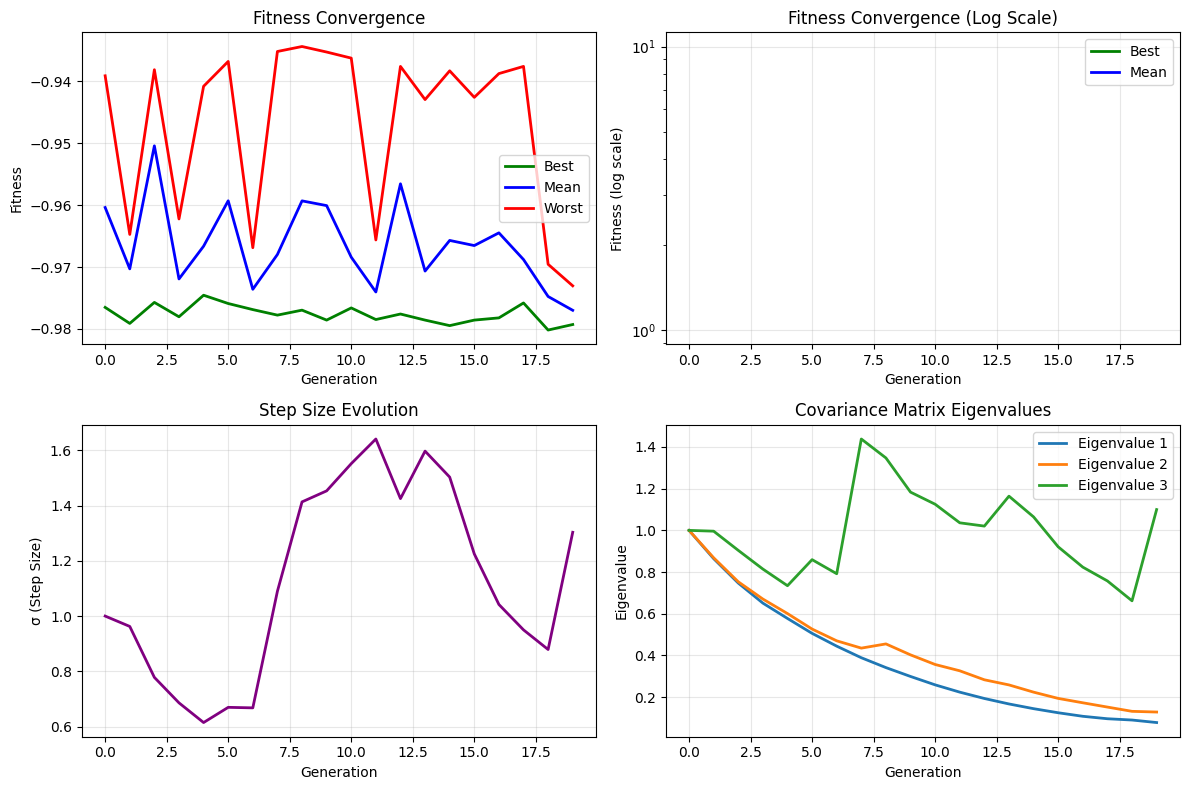

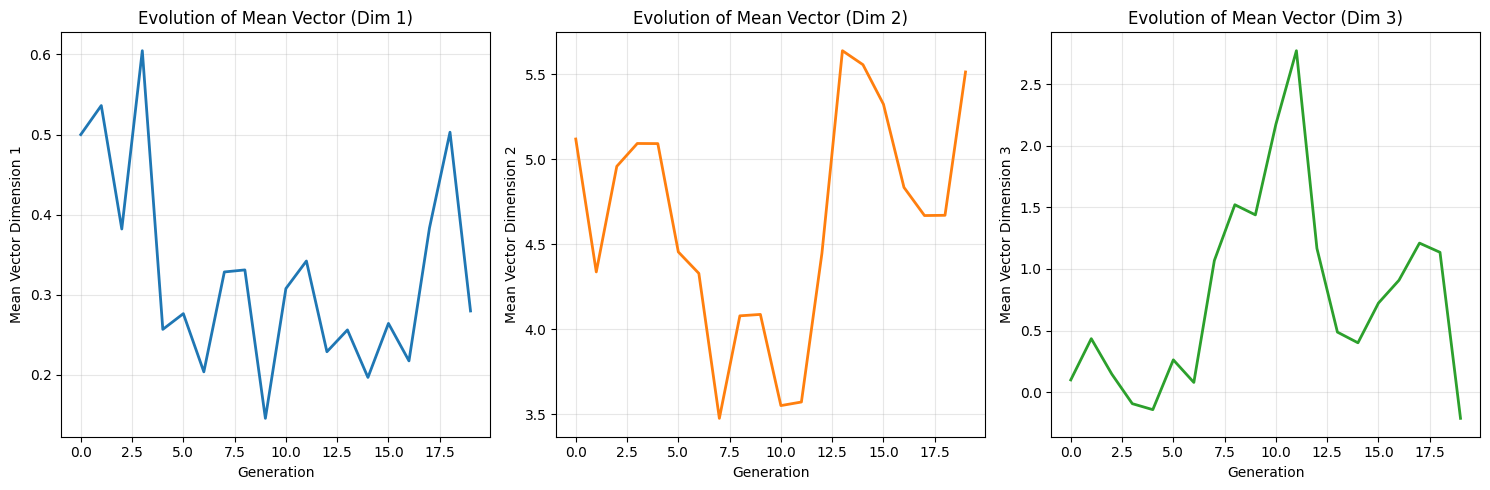

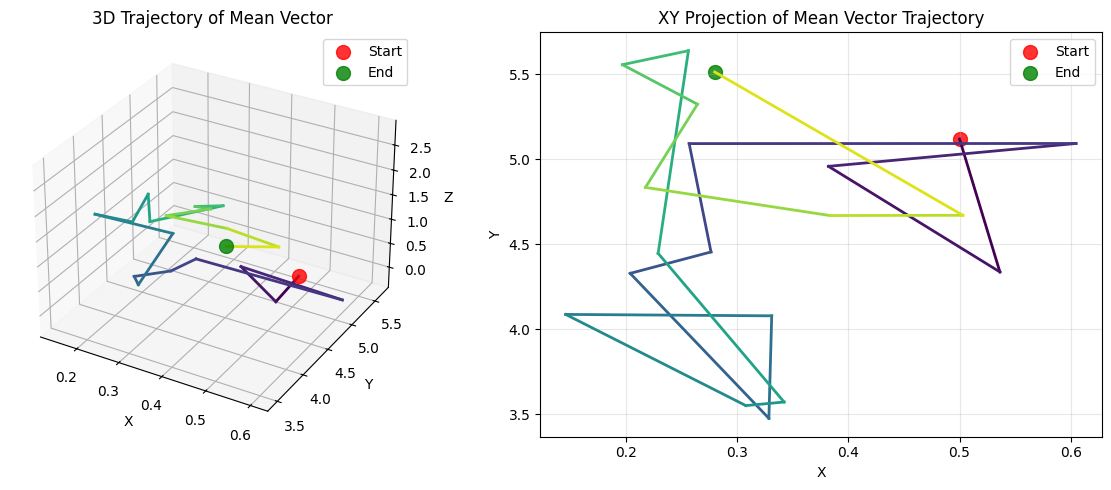

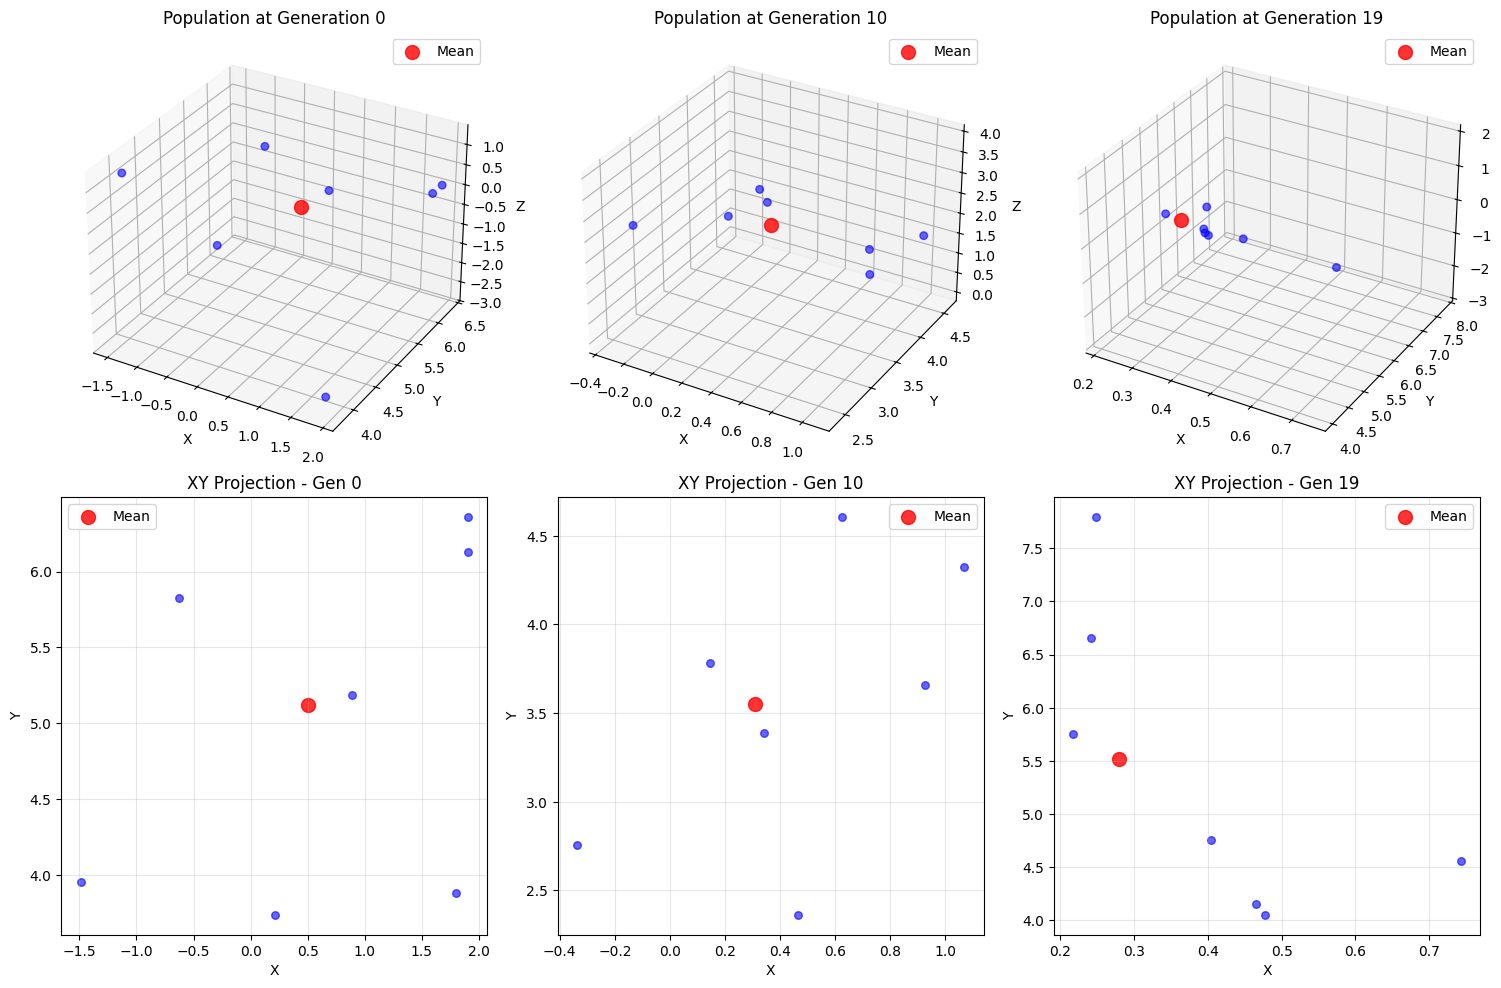

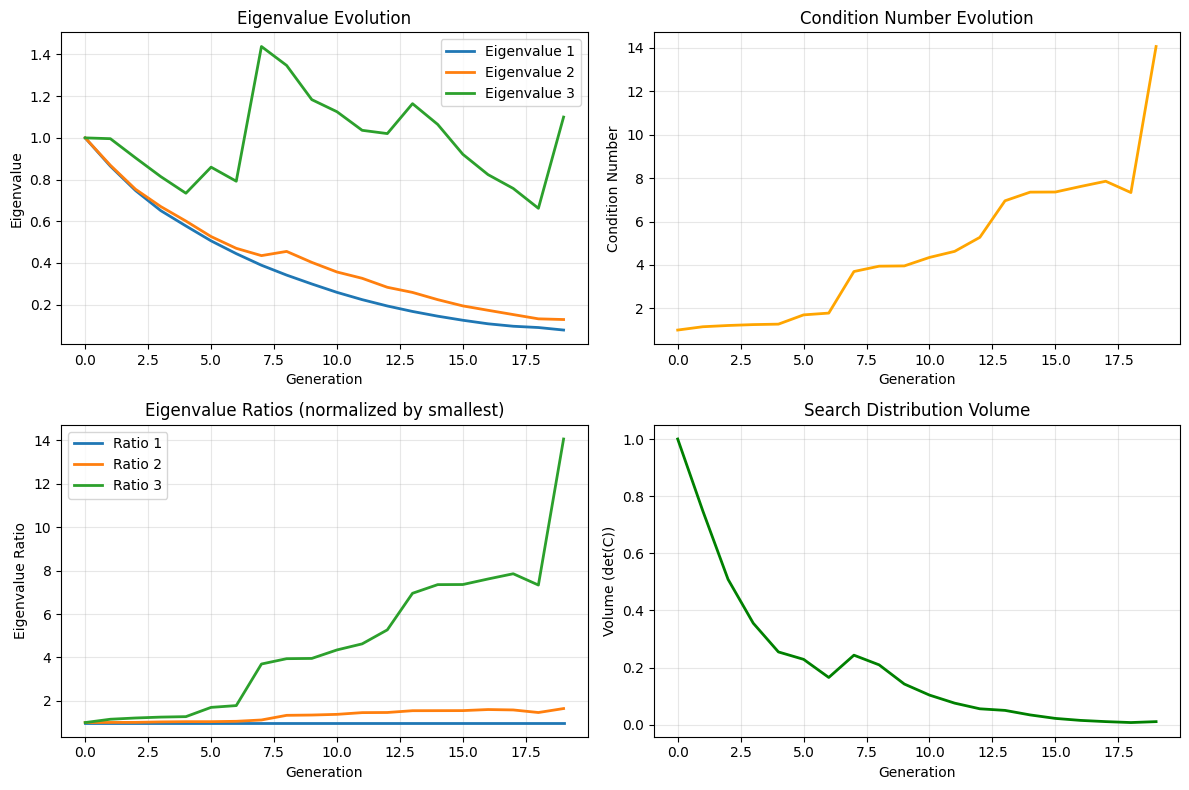

In [50]:
data = analyzer.comprehensive_analysis()
plt.show(data)

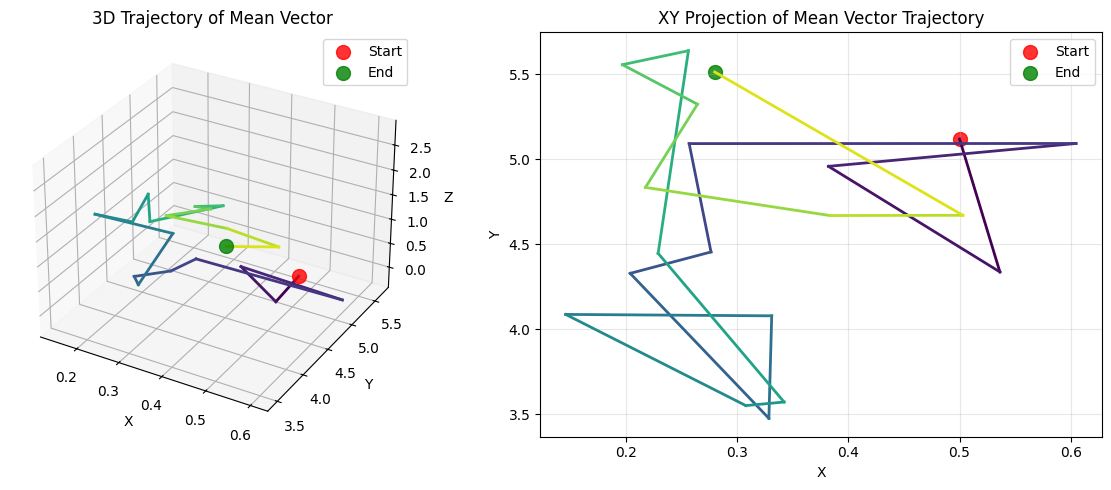

In [49]:
data_3d = analyzer.plot_3d_trajectory()
plt.show(data_3d)